In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data = pd.read_csv('/content/misch.csv')

Statistical description of the data

In [ ]:
new_data = data.drop(columns=data.columns[[0,6,7,9]])
new_data.head()


,VOL,AREA_F,APT_NUM,ST_NUM,KREIS,YOC,MINERAL
0,1328,119,5,5,10,1933,325.00
1,1016,109,5,4,10,1938,325.00
2,915,95,1,4,11,1933,300.00
3,1658,160,6,5,9,1941,224.55
4,1745,160,6,5,9,1941,390.00


One-hot encode of categorical data


In [ ]:
new_data['KREIS'] = new_data['KREIS'].astype('category')
#new_data['ZIPCODE'] = new_data['ZIPCODE'].astype('category')
# One-hot encode the data using pandas get_dummies
new_data = pd.get_dummies(new_data)
print
print(new_data.columns)
print(new_data.shape)

Index(['VOL', 'AREA_F', 'APT_NUM', 'ST_NUM', 'YOC', 'MINERAL', 'KREIS_2',
       'KREIS_3', 'KREIS_4', 'KREIS_6', 'KREIS_7', 'KREIS_8', 'KREIS_9',
       'KREIS_10', 'KREIS_11', 'KREIS_12'],
      dtype='object')
(309, 16)


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Split data into TEST (T) that I don't touch and train + validation set (TV)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# labels as numpy array
Y=np.array(new_data['MINERAL'])

#features as numpy array
X_list= new_data.drop(columns='MINERAL')
X = np.array(X_list)

#save headers for later
headers = list(X_list.columns)

X_TV, X_T, Y_TV, Y_T = train_test_split(X,Y,test_size = 0.15, random_state = 296) #this split, meaning, this random seed, has to be the same for all the models!

print(X_T, Y_T)

[[2167  175    6    5 1934    0    0    0    1    0    0    0    0    0
     0]
 [1644  169    6    5 1948    0    0    0    0    0    0    1    0    0
     0]
 [ 375   55    1    2 1943    0    0    0    0    0    0    1    0    0
     0]
 [1848  181    3    5 1934    0    0    0    0    0    0    0    1    0
     0]
 [1735  161    6    5 1942    0    0    0    0    0    0    1    0    0
     0]
 [ 382   52    1    4 1949    0    0    0    0    0    0    0    0    1
     0]
 [2301  187    8    6 1930    0    0    0    0    0    0    1    0    0
     0]
 [1942  174    6    5 1950    0    0    0    0    0    0    0    0    1
     0]
 [1535  274    1    5 1926    1    0    0    0    0    0    0    0    0
     0]
 [2099  204    9    5 1960    0    1    0    0    0    0    0    0    0
     0]
 [ 548   63    2    5 1919    0    0    0    1    0    0    0    0    0
     0]
 [ 961  131    1    4 1949    0    0    0    0    0    0    0    0    1
     0]
 [1776  165    6    5 1950    0    0    

Hyperparameter search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model_pipe = xgb.XGBRegressor(objective='reg:squarederror')

#Metrics for Evualation:
met_grid= ['r2', 'neg_mean_absolute_error'] #The metric codes from sklearn

# Create the parameter grid based on the results of random search 
params = {
           'max_depth': [9],
        'min_child_weight': [1],
        'gamma': [10000],
        'learning_rate': [0.01],
        'subsample': [0.8],
        'colsample_bylevel': [0.9],
        'colsample_bytree': [0.8],
        'n_estimators': [400],
        'alpha' : [1000]
      }

# Instantiate the grid search model
grid_search = RandomizedSearchCV(model_pipe, param_distributions = params, scoring = met_grid, refit = 'r2', n_iter = 500,
                                cv = 10, n_jobs = 1, verbose = 10, return_train_score = True)
# Fit the grid search to the data
grid_search.fit(X_TV, Y_TV)

from google.colab import files

gd_w = pd.DataFrame(grid_search.cv_results_)
gd_w.to_csv('grid_search_mi_xgb3.csv', encoding = 'utf-8-sig') 
files.download('grid_search_mi_xgb3.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 7 is smaller than n_iter=500. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10; 1/7] START alpha=1000, colsample_bylevel=0.9, colsample_bytree=0.8, gamma=10000, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8
[CV 1/10; 1/7] END alpha=1000, colsample_bylevel=0.9, colsample_bytree=0.8, gamma=10000, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8; neg_mean_absolute_error: (train=-65.963, test=-114.423) r2: (train=0.868, test=0.536) total time=   0.2s
[CV 2/10; 1/7] START alpha=1000, colsample_bylevel=0.9, colsample_bytree=0.8, gamma=10000, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8
[CV 2/10; 1/7] END alpha=1000, colsample_bylevel=0.9, colsample_bytree=0.8, gamma=10000, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8; neg_mean_absolute_error: (train=-64.902, test=-90.337) r2: (train=0.875, test=0.682) total time=   0.2s
[CV 3/10; 1/7] START alpha=1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

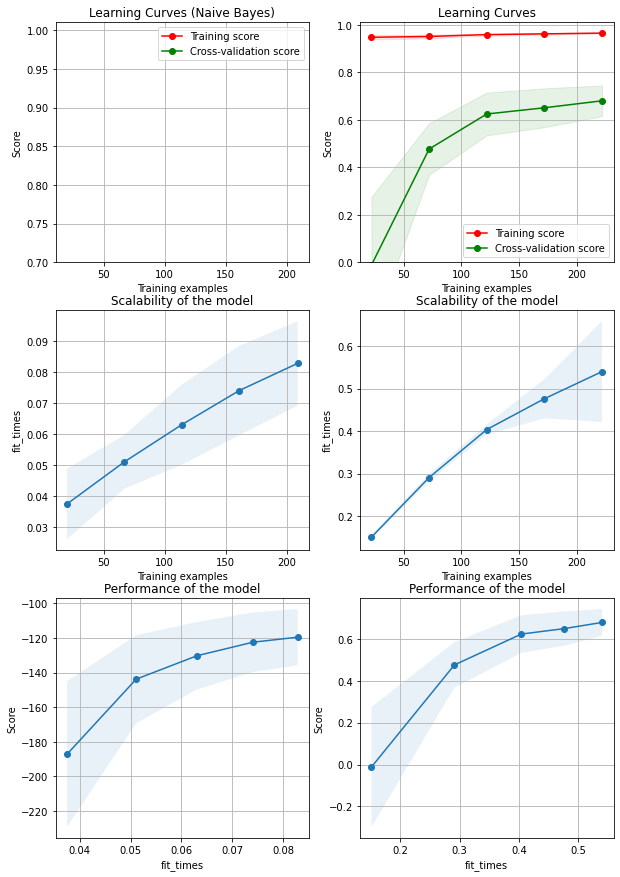

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = X_TV, Y_TV

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = xgb.XGBRegressor(objective='reg:squarederror')
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="neg_mean_absolute_error",
)

title = r"Learning Curves"

cv = ShuffleSplit(n_splits=3, test_size=0.15, random_state=0)
estimator = xgb.XGBRegressor(objective='reg:squarederror', 
          max_depth=9,
        min_child_weight=1,
        gamma= 10000,
        learning_rate=0.01,
      subsample=0.8,
        colsample_bylevel = 0.9,
        colsample_bytree=0.8,
        n_estimators= 400,
        alpha = 1000)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01), cv=cv, n_jobs=4
)

plt.show()

Apply chosen hyperparams

In [2]:
cv_results_ = pd.read_csv('/content/grid_search_mi_xgb3.csv')

Test on a Validation set

In [ ]:
### THIS IS NOT NECESSARY, JUST A SANITY CHECK WHICH CONFIRMS THE NUMBERS FROM THE .csv ############

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from statistics import mean

# Create the parameter grid based on the results of random search

chosen_index = 5 #grid_search_w_xgb3.csv

print(cv_results_['params'][chosen_index])
tv_rf = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth = cv_results_['param_max_depth'][chosen_index],
    min_child_weight = cv_results_['param_min_child_weight'][chosen_index],
    gamma = cv_results_['param_gamma'][chosen_index],
    learning_rate = cv_results_['param_learning_rate'][chosen_index],
    subsample = cv_results_['param_subsample'][chosen_index],
    colsample_bylevel = cv_results_['param_colsample_bylevel'][chosen_index],
    colsample_bytree = cv_results_['param_colsample_bytree'][chosen_index],
    alpha = cv_results_['param_alpha'][chosen_index],
    n_estimators = cv_results_['param_n_estimators'][chosen_index]
)

# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
mae_v = cross_val_score(tv_rf, X_TV, Y_TV, scoring='neg_mean_absolute_error', cv=10, n_jobs=1)

# report performance
print('MAE:', (mean(mae_v)*(-1), "Standard deviation: ", np.std(mae_v)))

r2_v = cross_val_score(tv_rf, X_TV, Y_TV, scoring='r2', cv=10, n_jobs=1)
print('R2', (mean(r2_v), "Standard deviation: ", np.std(r2_v)))


{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 10000, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'alpha': 1000}
MAE: (96.13277449521448, 'Standard deviation: ', 11.06403659774886)
R2 (0.6486095238994366, 'Standard deviation: ', 0.11799550375508801)


Read Train + Validation results

Validation r2 score:  0.65 
 Standard deviation:  0.12
Train r2 score:  0.96 
 Standard deviation:  0.0
Validation MAE score:  -96.13 
 Standard deviation:  11.06
Train MAE score:  -34.29 
 Standard deviation:  0.37


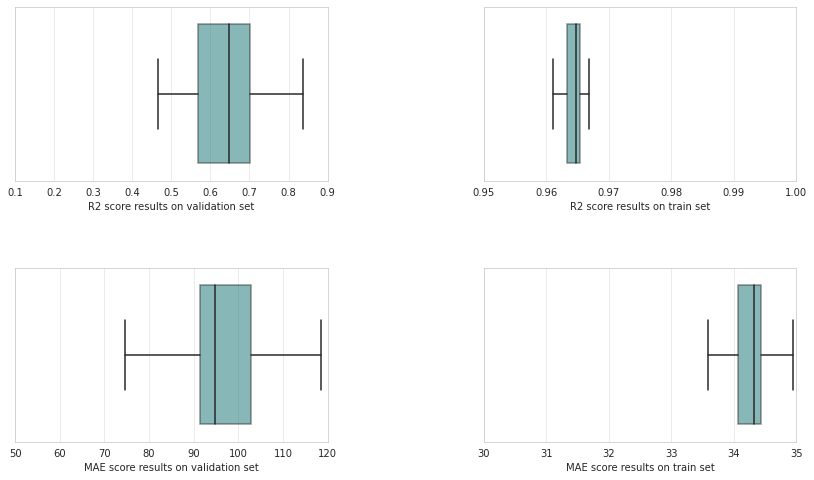

In [4]:
chosen_index = 5 #grid_search_w_xgb_f.csv

r2_v = []
mae_v = []
r2_tr = []
mae_tr = []

for i in range (10):
  v_r2 = "split"+str(i)+"_test_r2"  
  v_mae = "split"+str(i)+"_test_neg_mean_absolute_error"
  r2_v.append(cv_results_[v_r2][chosen_index])
  mae_v.append(cv_results_[v_mae][chosen_index]*(-1))

  tr_r2 = "split"+str(i)+"_train_r2"  
  tr_mae = "split"+str(i)+"_train_neg_mean_absolute_error"
  r2_tr.append(cv_results_[tr_r2][chosen_index])
  mae_tr.append(cv_results_[tr_mae][chosen_index]*(-1))

print("Validation r2 score: ", round(cv_results_['mean_test_r2'][chosen_index],2), "\n Standard deviation: ", round(cv_results_['std_test_r2'][chosen_index],2) )
print("Train r2 score: ", round(cv_results_['mean_train_r2'][chosen_index],2),"\n Standard deviation: ", round(cv_results_['std_train_r2'][chosen_index],2))
print("Validation MAE score: ", round(cv_results_['mean_test_neg_mean_absolute_error'][chosen_index],2), "\n Standard deviation: ", round(cv_results_['std_test_neg_mean_absolute_error'][chosen_index],2) )
print("Train MAE score: ", round(cv_results_['mean_train_neg_mean_absolute_error'][chosen_index],2),"\n Standard deviation: ", round(cv_results_['std_train_neg_mean_absolute_error'][chosen_index],2))
metrics_TV = pd.DataFrame(list(zip(r2_v,mae_v,r2_tr,mae_tr)), columns =['r2_validation', 'MAE_validation', 'r2_train', 'MAE_train',])

spacing = 0.5
f = plt.figure(figsize=(14,8))
gs = f.add_gridspec(2, 2)
gs.update(wspace = spacing, hspace = spacing)


with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(data=metrics_TV, x="r2_validation", color = "teal", boxprops=dict(alpha=.5)).set(
    xlabel='R2 score results on validation set')
    plt.xlim(0.1,0.9)

with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(data=metrics_TV, x="r2_train", color = "teal", boxprops=dict(alpha=.5)).set(
    xlabel='R2 score results on train set')
    plt.xlim(0.95,1)

with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[1, 0])
    sns.boxplot(data=metrics_TV, x="MAE_validation", color = "teal", boxprops=dict(alpha=.5)).set(
    xlabel='MAE score results on validation set')
    plt.xlim(50,120)

with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[1, 1])
    sns.boxplot(data=metrics_TV, x="MAE_train", color = "teal", boxprops=dict(alpha=.5)).set(
    xlabel='MAE score results on train set')
    plt.xlim(30,35)

f.savefig('misch_xb.png')


Hyperparameters applied to (T) set


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

r2=[]
MAE=[]

t_rf = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth = cv_results_['param_max_depth'][chosen_index],
    min_child_weight = cv_results_['param_min_child_weight'][chosen_index],
    gamma = cv_results_['param_gamma'][chosen_index],
    learning_rate = cv_results_['param_learning_rate'][chosen_index],
    subsample = cv_results_['param_subsample'][chosen_index],
    colsample_bylevel = cv_results_['param_colsample_bylevel'][chosen_index],
    colsample_bytree = cv_results_['param_colsample_bytree'][chosen_index],
    alpha = cv_results_['param_alpha'][chosen_index],
    n_estimators = cv_results_['param_n_estimators'][chosen_index]
)


t_rf.fit(X_TV, Y_TV)

# Get Y predicted
predictions=t_rf.predict(X_T)

# Print out the mean absolute error (mae)
MAE = round(mean_absolute_error(Y_T, predictions),2)
print('Mean Absolute Error:', MAE)

# Print out R2
print('R2:', round(r2_score(Y_T, predictions),2))

Mean Absolute Error: 74.93
R2: 0.64


Fitted vs Actual plot (Test set)

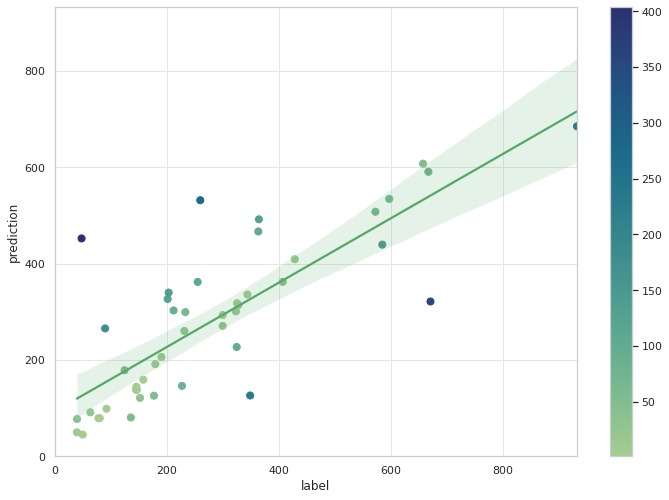

In [ ]:
# Visualising  results
limit = max(Y_T)
predictions = t_rf.predict(X_T)
mae = np.round(abs(Y_T - predictions))
d = {'label': Y_T, 'prediction': predictions, 'mae': mae}
plot = pd.DataFrame(data = d)
# plot absolute settings
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {"grid.color": ".9"})

points = plt.scatter(d["label"], d["prediction"], s=50, c=d["mae"], cmap="crest")
plt.colorbar(points)
plt.xlim(0, limit)
plt.ylim(0, limit)

sns.regplot(
    x="label", y="prediction", data=plot, scatter = False, color='g')
 

Absolute error in the test set plot

In [ ]:
# Visualising the Random Forest Regression results
n =  #number of data points

sns.set_style("whitegrid", {"grid.color": ".9"})
numbers = np.array(list(range(0,int(n),+1)))

value = np.round(abs(Y_T - predictions))
d = {'Absolute error': value, 'dataset': numbers}
plot = pd.DataFrame(data = d)

sns.displot(data = plot, x="dataset", y="Absolute error", height=7,
    aspect=1, binwidth=(4, 4), cmap="YlOrBr")

sns.lineplot(data = plot, x="dataset", y=MAE, color = 'chocolate')

ValueError: ignored

Feature importance

In [ ]:
from scipy.special import softmax
from sklearn.feature_selection import SelectFwe, chi2

def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = t_rf.feature_importances_
    features = headers
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
# Prints the feature importances
print_feature_importances_random_forest(t_rf)

KREIS_3 -> 0.2111
APT_NUM -> 0.0963
KREIS_4 -> 0.0775
YOC -> 0.0741
KREIS_8 -> 0.0727
AREA_F -> 0.0718
MINERAL -> 0.0711
VOL -> 0.0680
KREIS_10 -> 0.0567
ST_NUM -> 0.0558
KREIS_6 -> 0.0520
KREIS_11 -> 0.0346
KREIS_2 -> 0.0323
KREIS_9 -> 0.0150
KREIS_7 -> 0.0111


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.3 MB/s 


In [ ]:
import shap
# Fits the explainer
explainer = shap.Explainer(t_rf, feature_names = headers)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

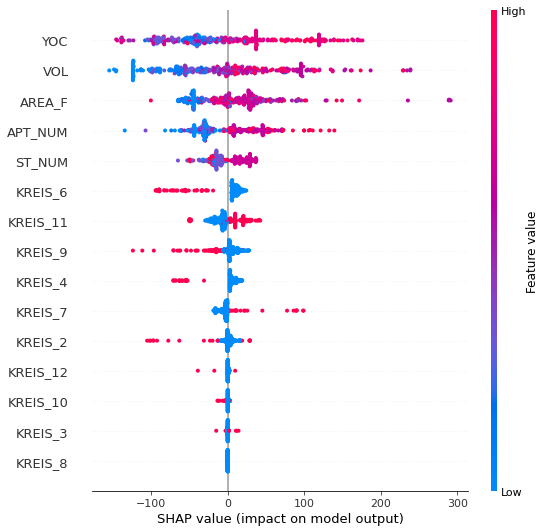

In [ ]:
shap.summary_plot(shap_values)